## DV2599 Project
Group 8


***
Viktor Fransson

vifr22@student.bth.se

***

Tobias Gustafsson

togu22@student.bth.se
***

#### Initialize

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load dataset
df = pd.read_csv('playground-series-s4e11/train.csv')
df_test = pd.read_csv('playground-series-s4e11/test.csv')
display(df.dtypes)


id                                         int64
Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

#### Pre-processing

In [2]:
# weird entries:
# Degree: 0, 29, 5.61, 5.56, B.03, 7.06, 24, 8.56, 5.88, B.3.79
# Dietary Habits: Yes, Pratham, BSc, Gender, 3, More Healthy, Less than Healthy, Mihir, 1.0, Hormonal, Electrician, No Healthy, Less Healthy, M.Tech, Vegas, No, Male, Indoor, Class 12, 2
# Profession: Moderate
# City: 3.0, Less than 5 Kalyan, No, Designer
# Sleep Duration: 40-45 hours, Moderate, 55-66 hours, Indore, 45, 35-36 hours, No, than 5 hours, 49 hours, Unhealthy, Work_Study_Hours, 45-48 hours, Pune

# Copy of df to change
df_munged = df.copy()

# Dietary habits
# values = ['Healthy', 'Moderate', 'Unhealthy']
# df_munged = df_munged[df_munged['Dietary Habits'].isin(values)]

# Sleep Duration
values = ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours']
df_munged = df_munged[df_munged['Sleep Duration'].isin(values)]

# Profession
# value_counts = df_munged['Profession'].value_counts()
# values = value_counts[value_counts >= 10].index
# df_munged['Profession'] = df_munged['Profession'].where(df_munged['Profession'].isin(values), other='other')

# Degree
# value_counts = df_munged['Degree'].value_counts()
# values = value_counts[value_counts >= 10].index
# df_munged['Degree'] = df_munged['Degree'].where(df_munged['Degree'].isin(values), other='other')
# df_munged = df_munged[df_munged['Degree'].isin(values)]


# Drops and split
x = df_munged.drop(['id', 'Name', 'Depression', 'City'], axis=1)
y = df_munged['Depression']

x.fillna({'Profession': 'none', 'Dietary Habits': 'none', 'Degree' : 'none'}, inplace=True) # CatBoost can't handle NaN in categorical features

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

display(x.dtypes)


# Analysis munge
df_ana = df.copy()
df_ana = df_ana.drop(columns=['id', 'Name'], axis=1)

feats_to_munge = ['City', 'Degree', 'Profession', 'Sleep Duration', 'Dietary Habits']

# Calculate and print value counts for each feature
for feat in feats_to_munge:
    # Count the occurrences of each value
    value_counts = df_ana[feat].value_counts()

    # Keep only values with 20 or more occurrences
    valid_values = value_counts[value_counts >= 15].index
    
    # Filter the dataframe to include only valid values
    if feat == 'Profession':    # Profession gets it own dataset due to removing too many instances otherwise
        df_prof = df_ana[df_ana[feat].isin(valid_values)]
    else:
        df_ana = df_ana[df_ana[feat].isin(valid_values)]

df_ana['CGPA'] = df_ana['CGPA'].round()

print(f"Removed {len(df['Age']) - len(df_ana['Age'])} instances")

Gender                                    object
Age                                      float64
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
dtype: object

Removed 319 instances


#### Data Analysis

Gender
Male      77464
Female    63236
Name: count, dtype: int64


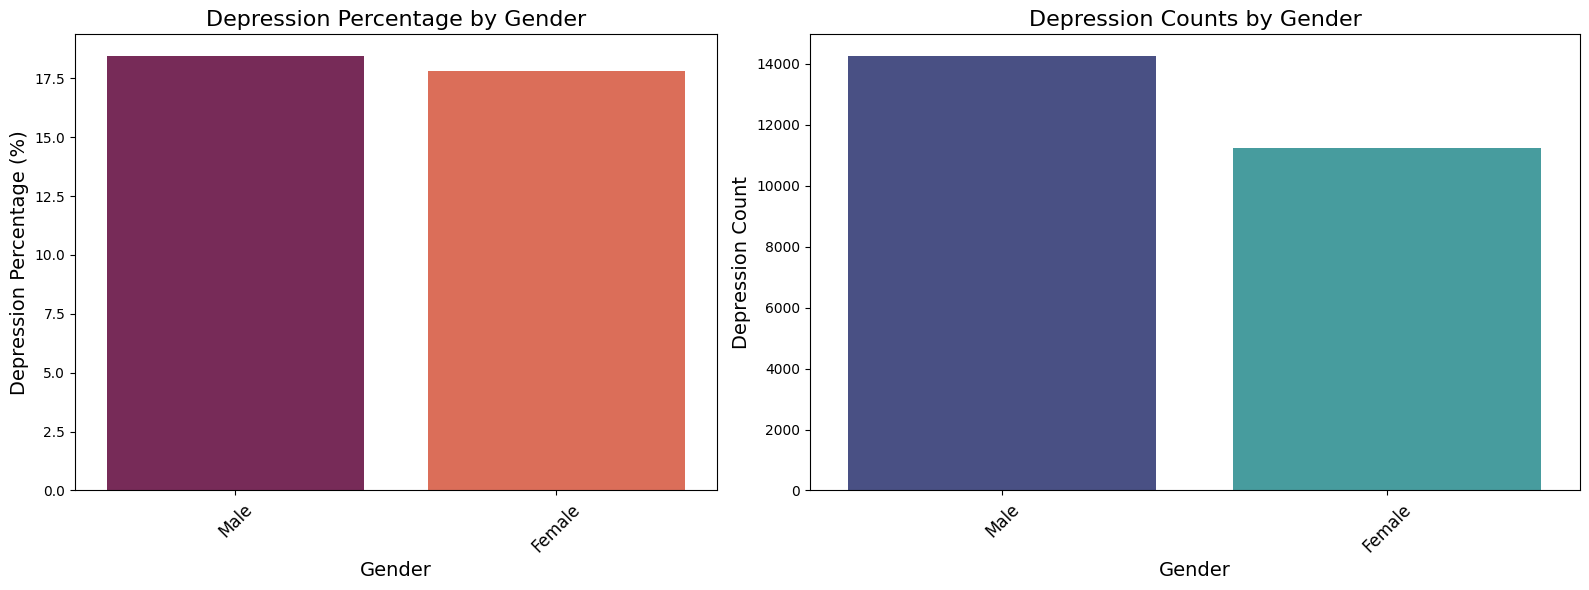

Age
56.0    5246
49.0    5099
38.0    4564
53.0    4526
57.0    4395
Name: count, dtype: int64


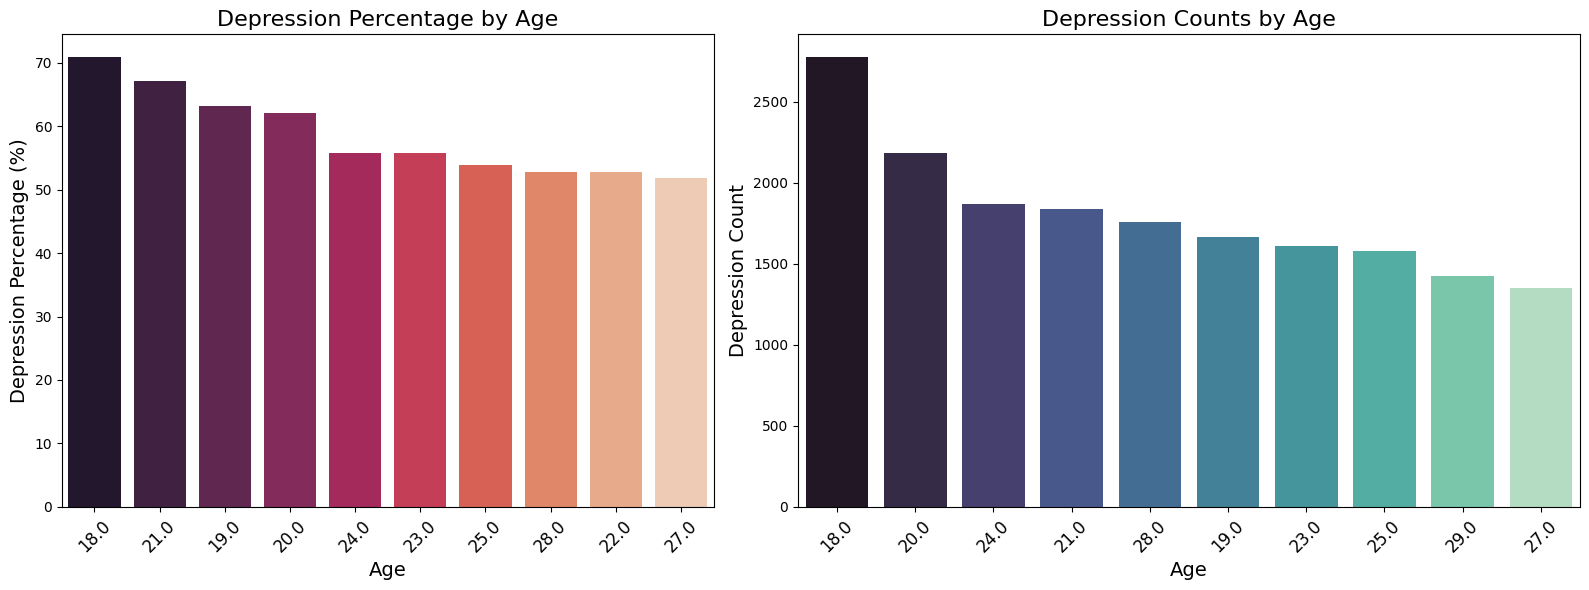

City
Kalyan         6591
Patna          5924
Vasai-Virar    5765
Kolkata        5689
Ahmedabad      5613
Name: count, dtype: int64


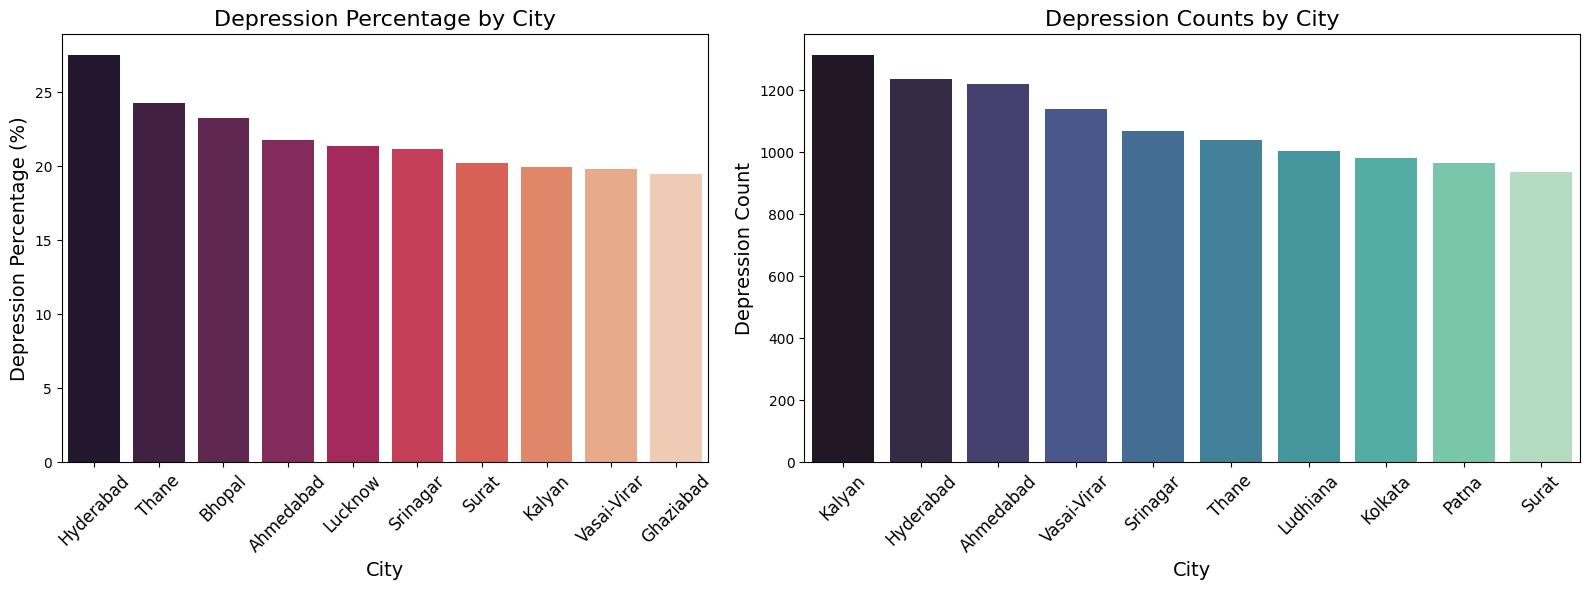

Working Professional or Student
Working Professional    112799
Student                  27901
Name: count, dtype: int64


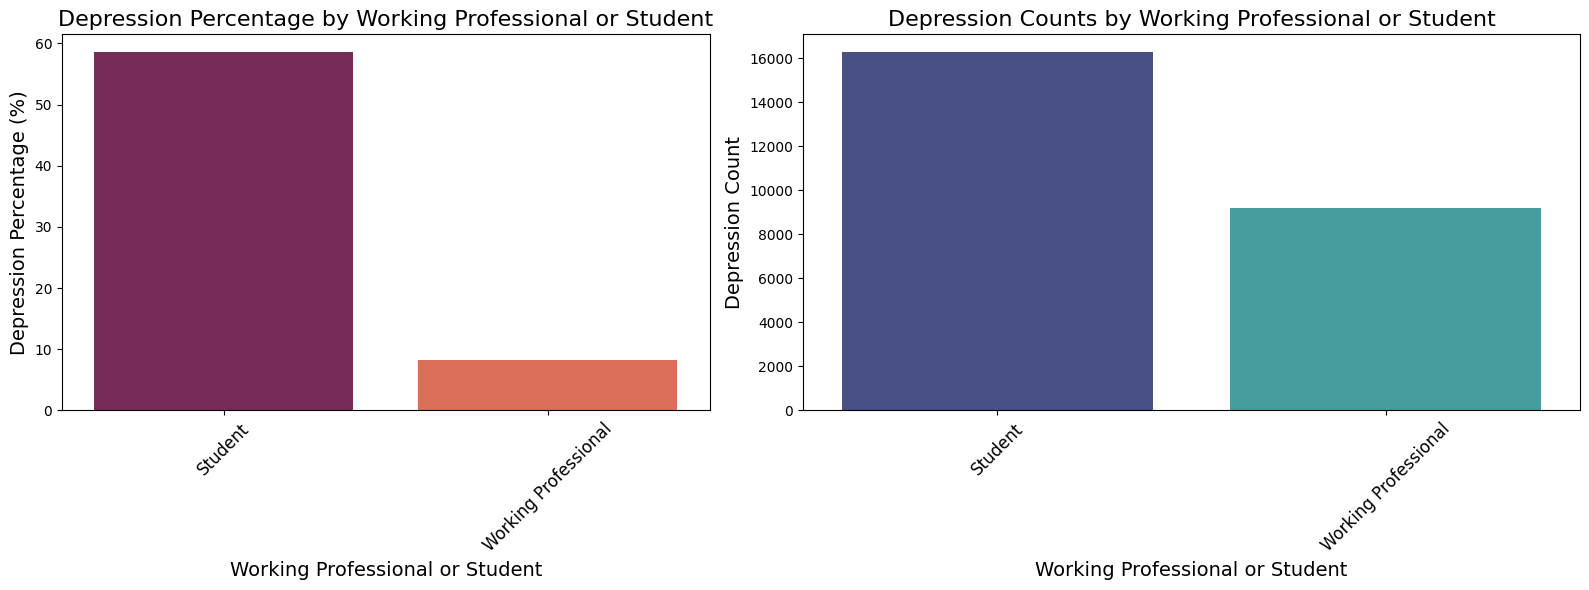

Profession
Teacher           24906
Content Writer     7814
Architect          4370
Consultant         4229
HR Manager         4022
Name: count, dtype: int64


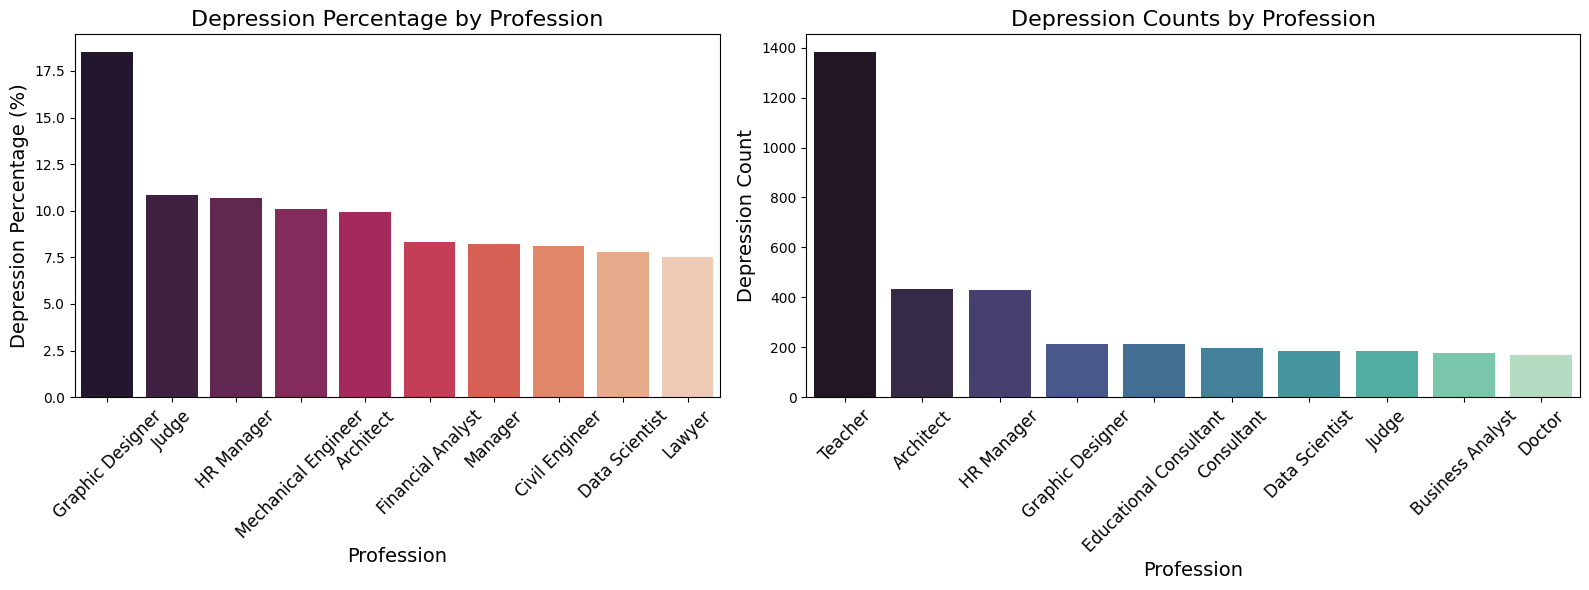

Academic Pressure
3.0    7463
5.0    6296
4.0    5158
1.0    4801
2.0    4179
Name: count, dtype: int64


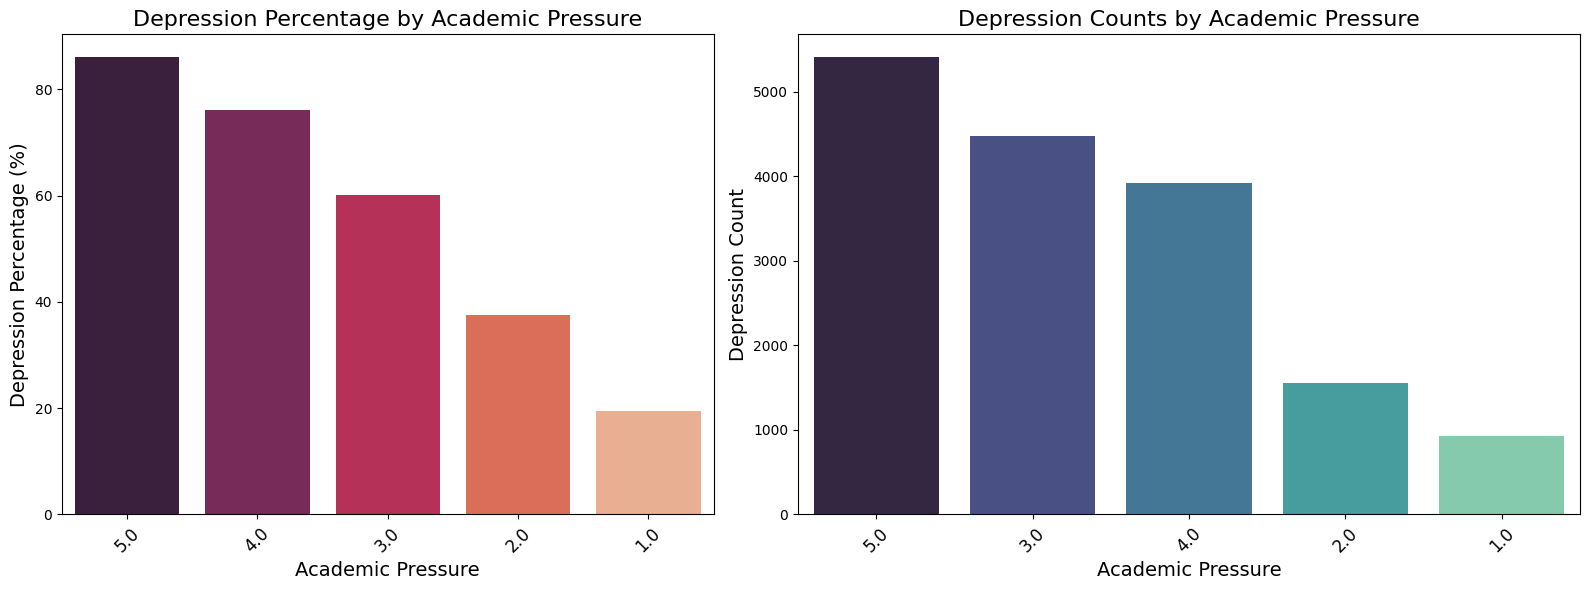

Work Pressure
2.0    24373
4.0    22512
5.0    22436
3.0    21899
1.0    21562
Name: count, dtype: int64


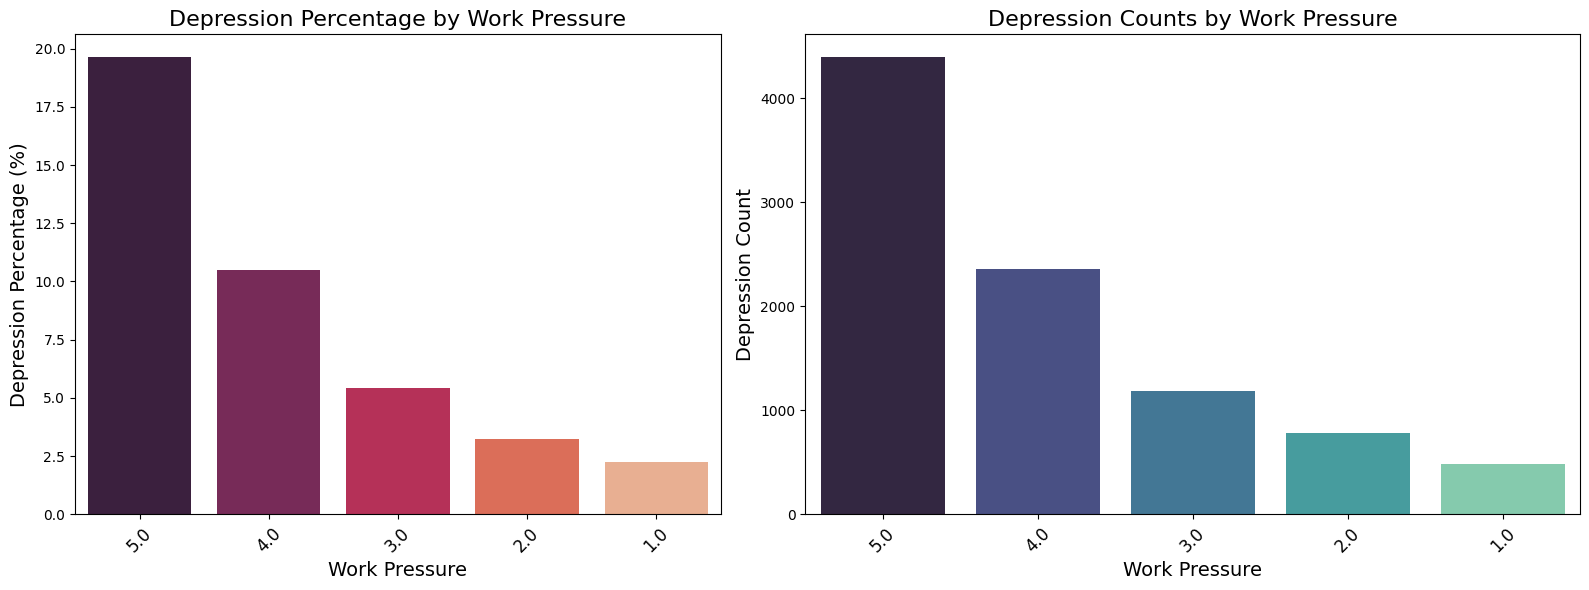

CGPA
8.04    822
9.96    425
5.74    410
8.95    371
9.21    343
Name: count, dtype: int64


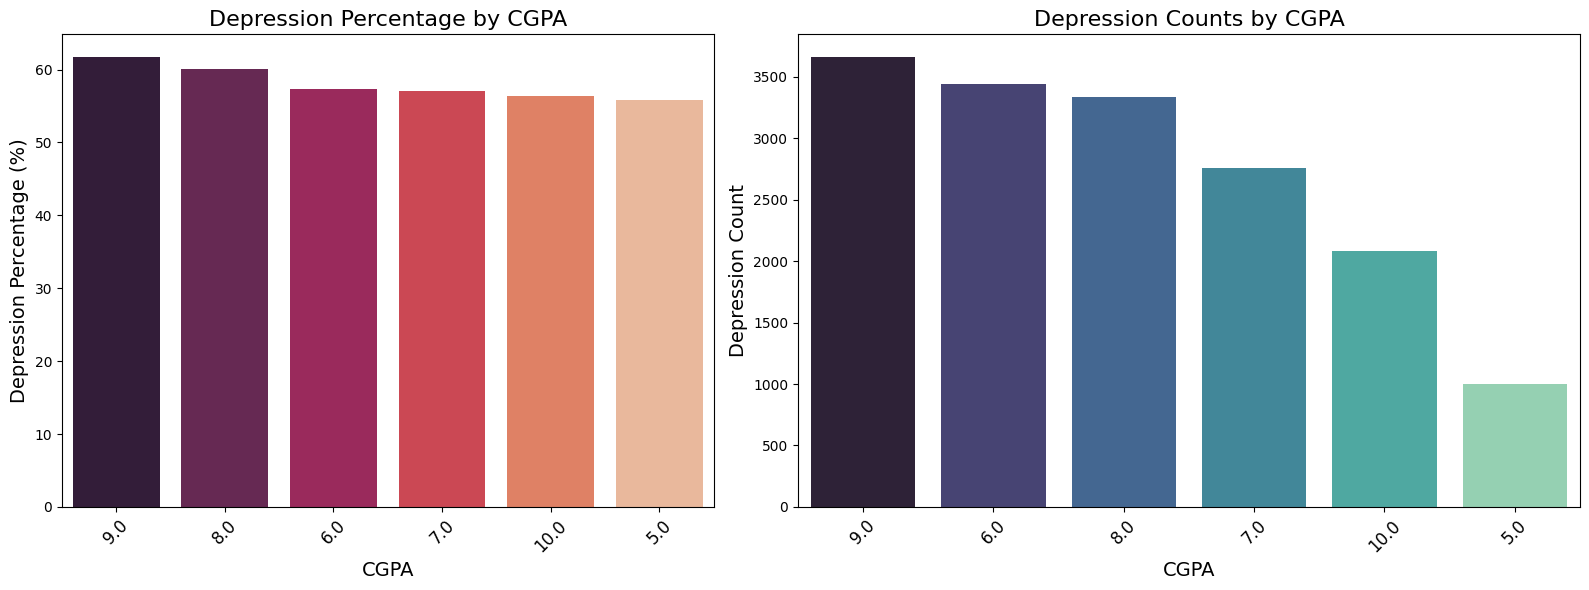

Study Satisfaction
4.0    6360
2.0    5840
3.0    5823
1.0    5451
5.0    4423
Name: count, dtype: int64


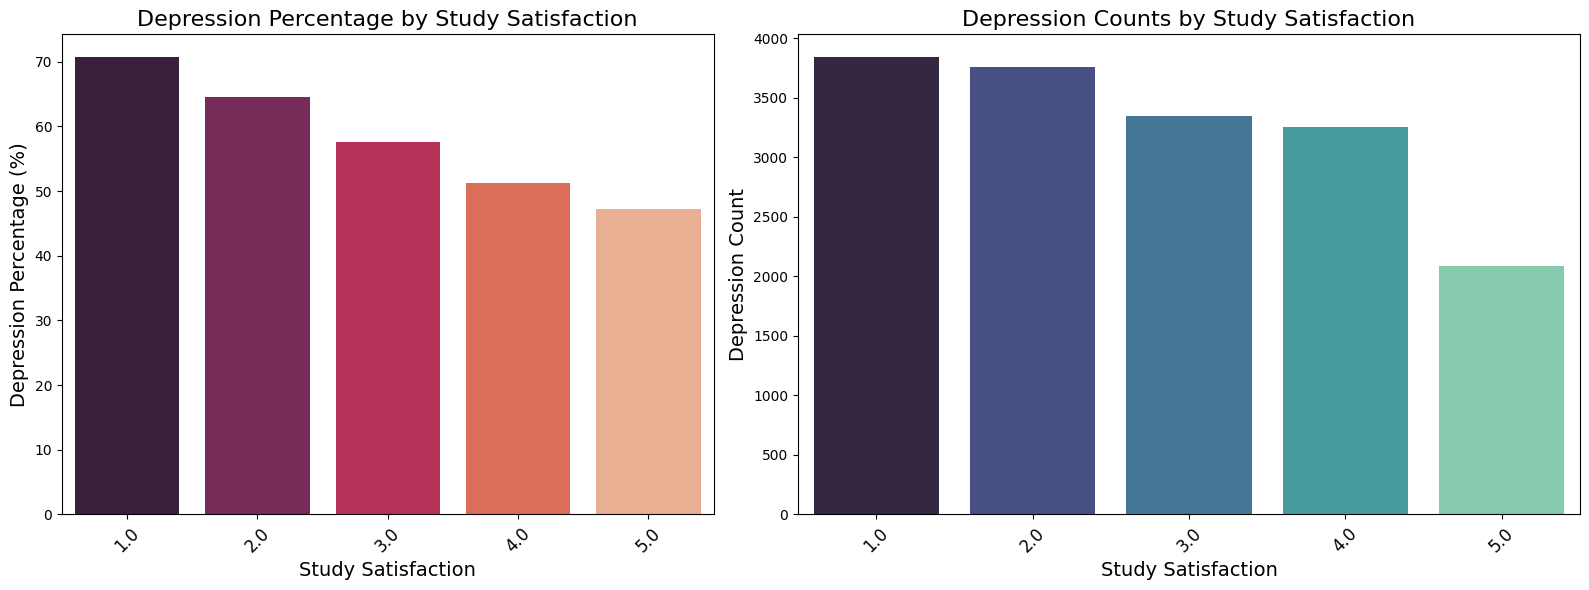

Job Satisfaction
2.0    24783
5.0    22812
1.0    22324
3.0    21951
4.0    20920
Name: count, dtype: int64


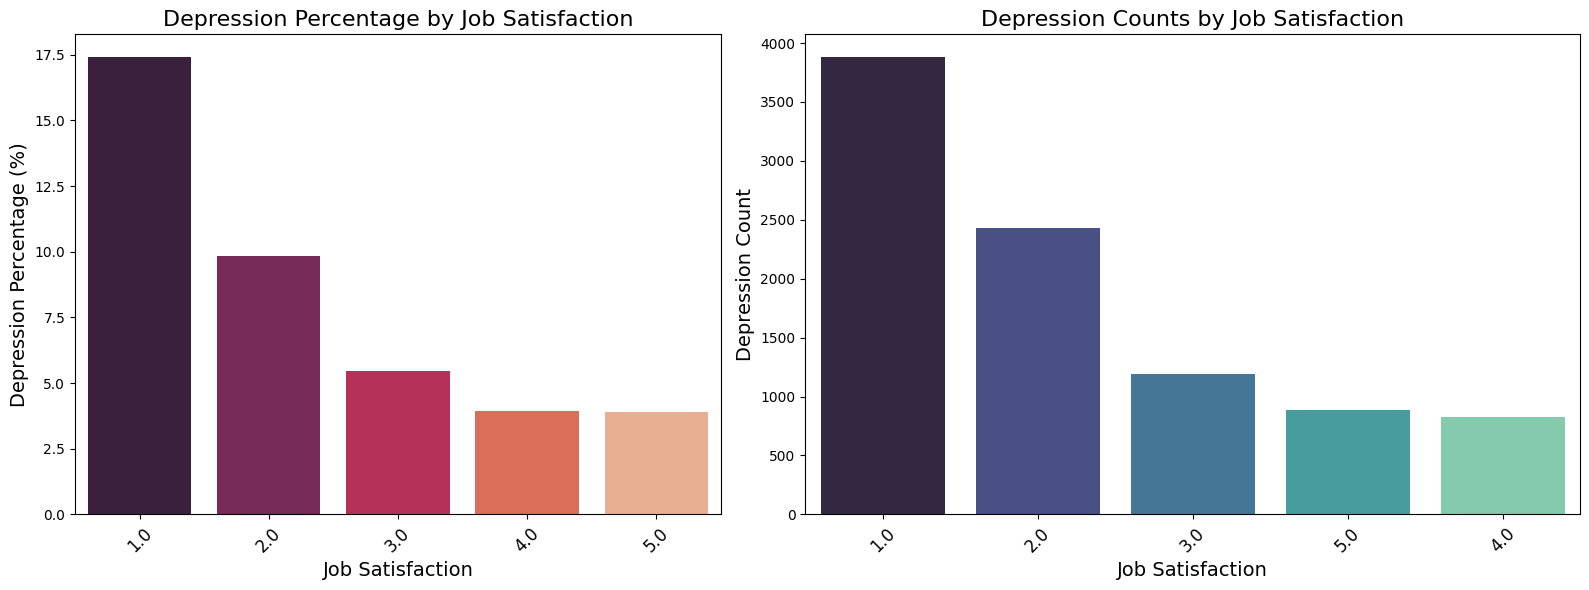

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
Name: count, dtype: int64


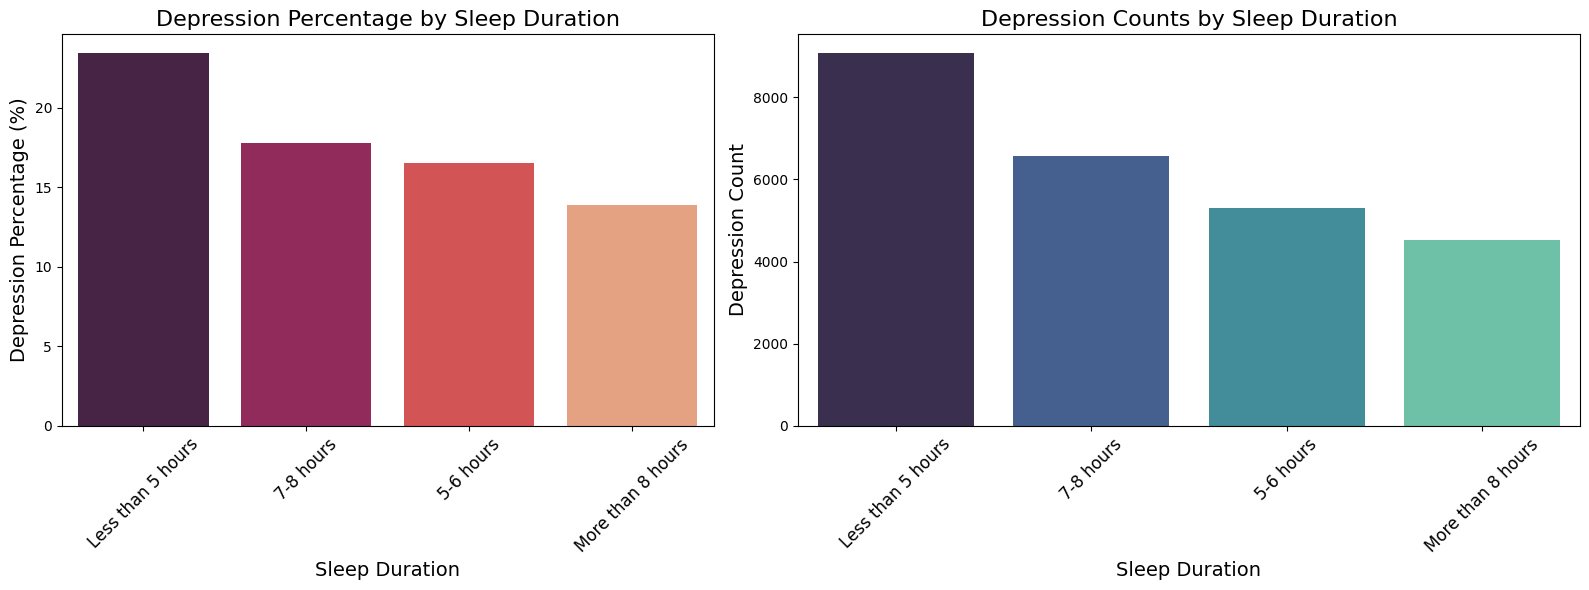

Dietary Habits
Moderate     49705
Unhealthy    46227
Healthy      44741
Yes              2
No               2
Name: count, dtype: int64


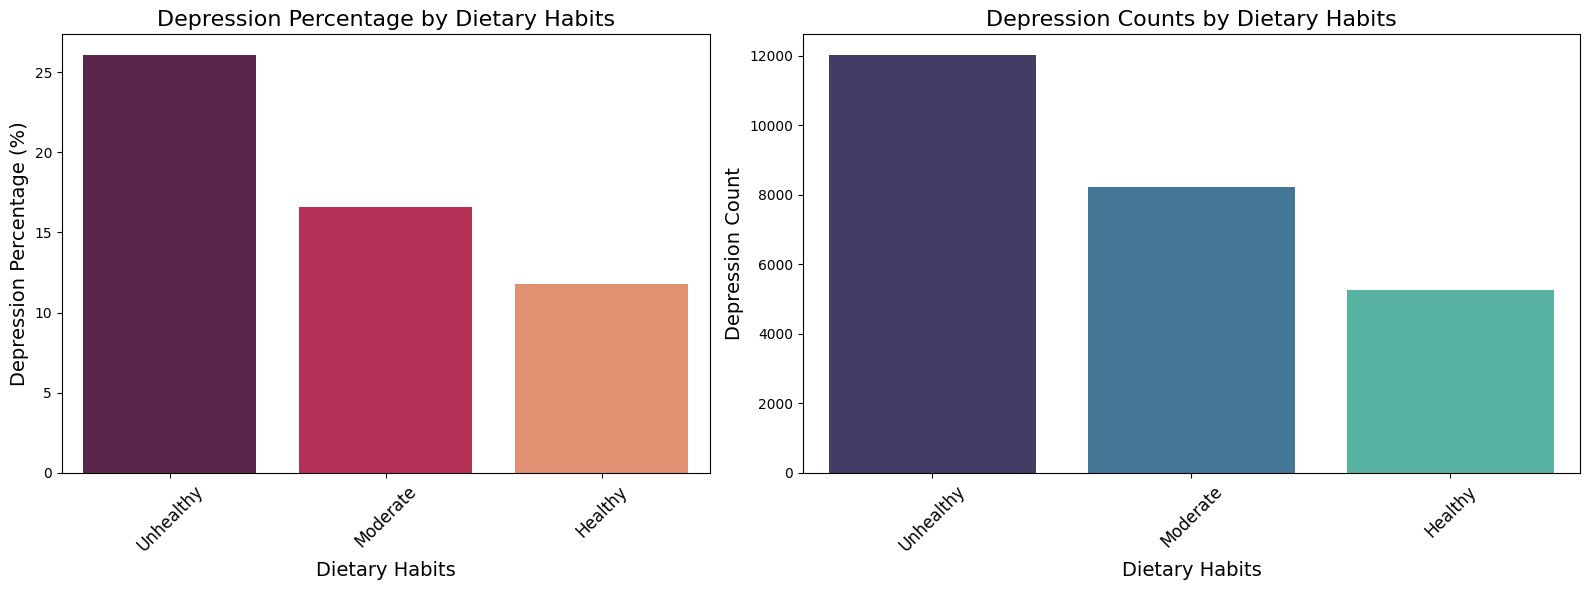

Degree
Class 12    14729
B.Ed        11691
B.Arch       8742
B.Com        8113
B.Pharm      5856
Name: count, dtype: int64


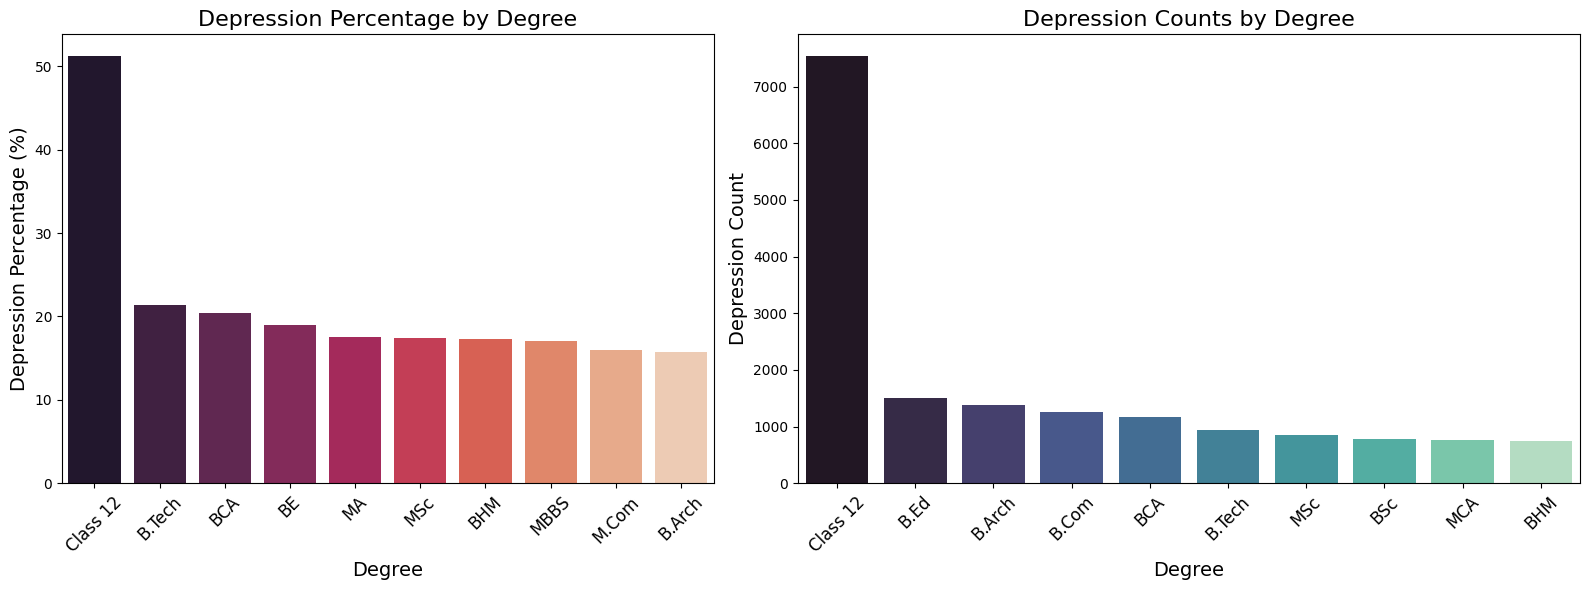

Have you ever had suicidal thoughts ?
No     71138
Yes    69562
Name: count, dtype: int64


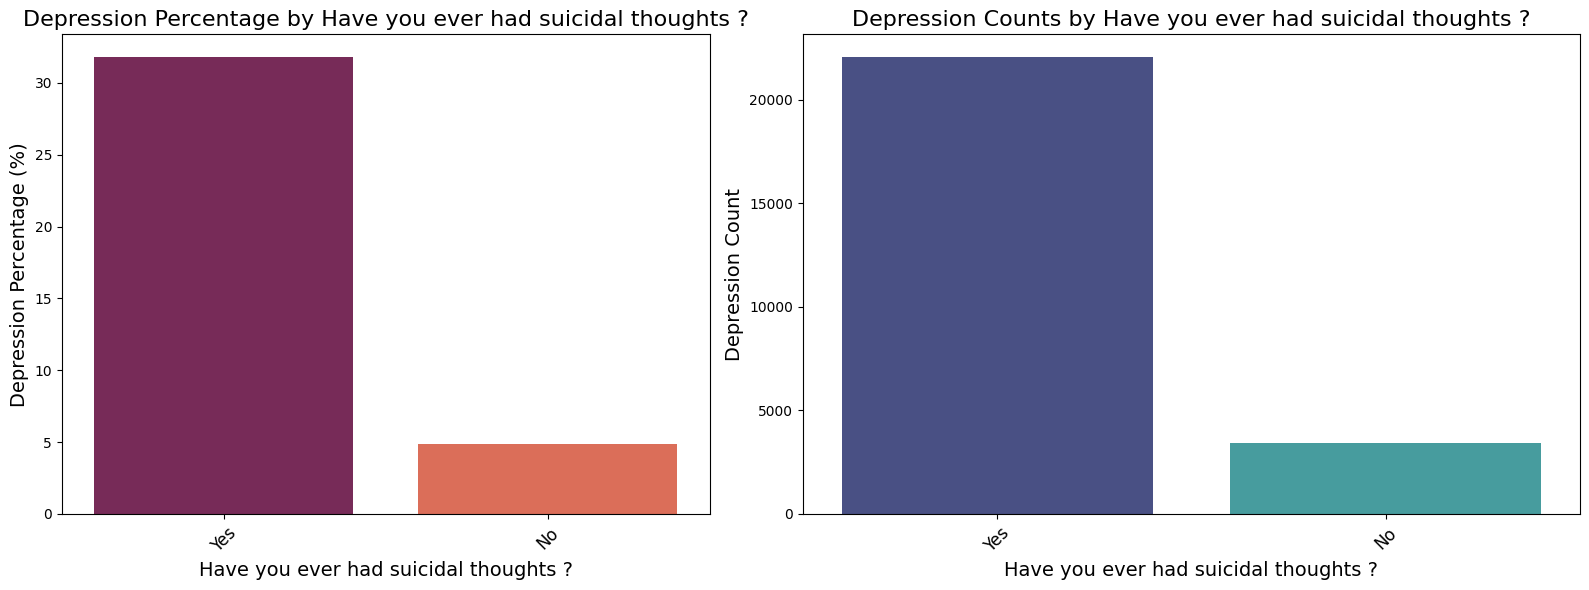

Work/Study Hours
10.0    14199
11.0    12832
9.0     12711
0.0     12066
12.0    11409
Name: count, dtype: int64


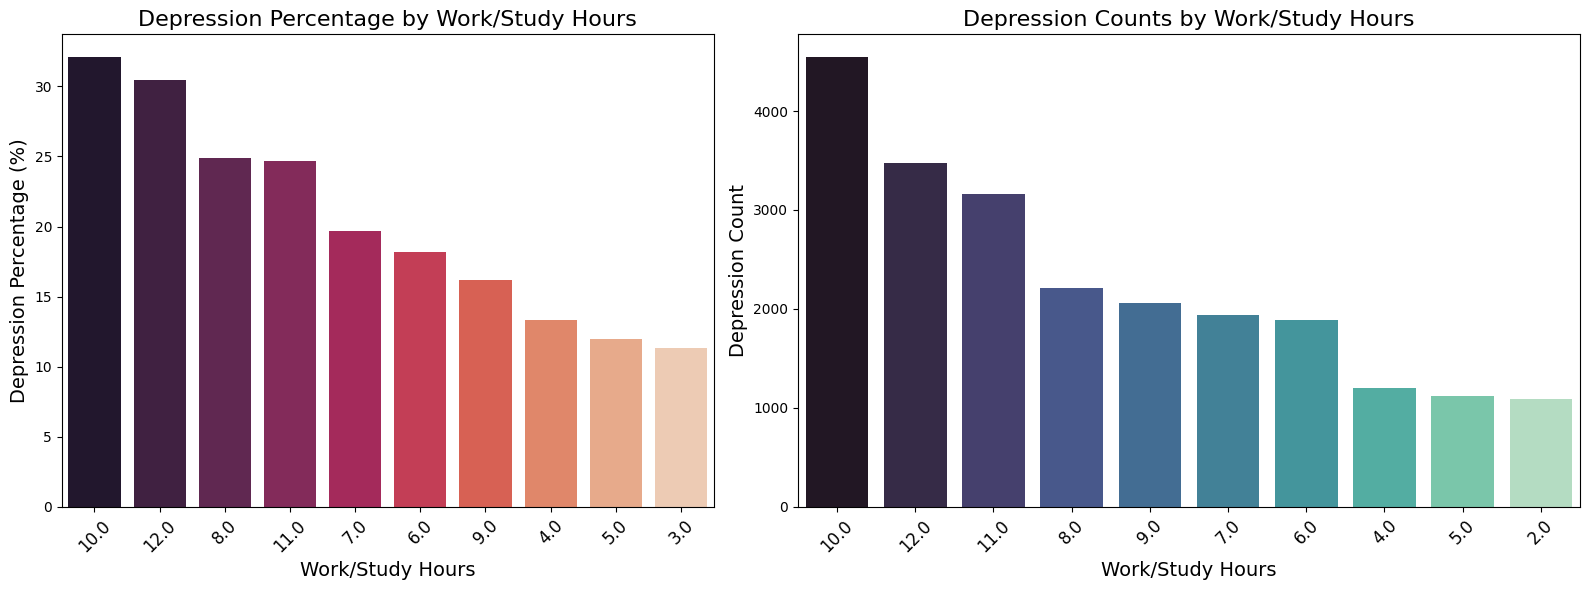

Financial Stress
2.0    31451
5.0    28279
4.0    27765
1.0    27211
3.0    25990
Name: count, dtype: int64


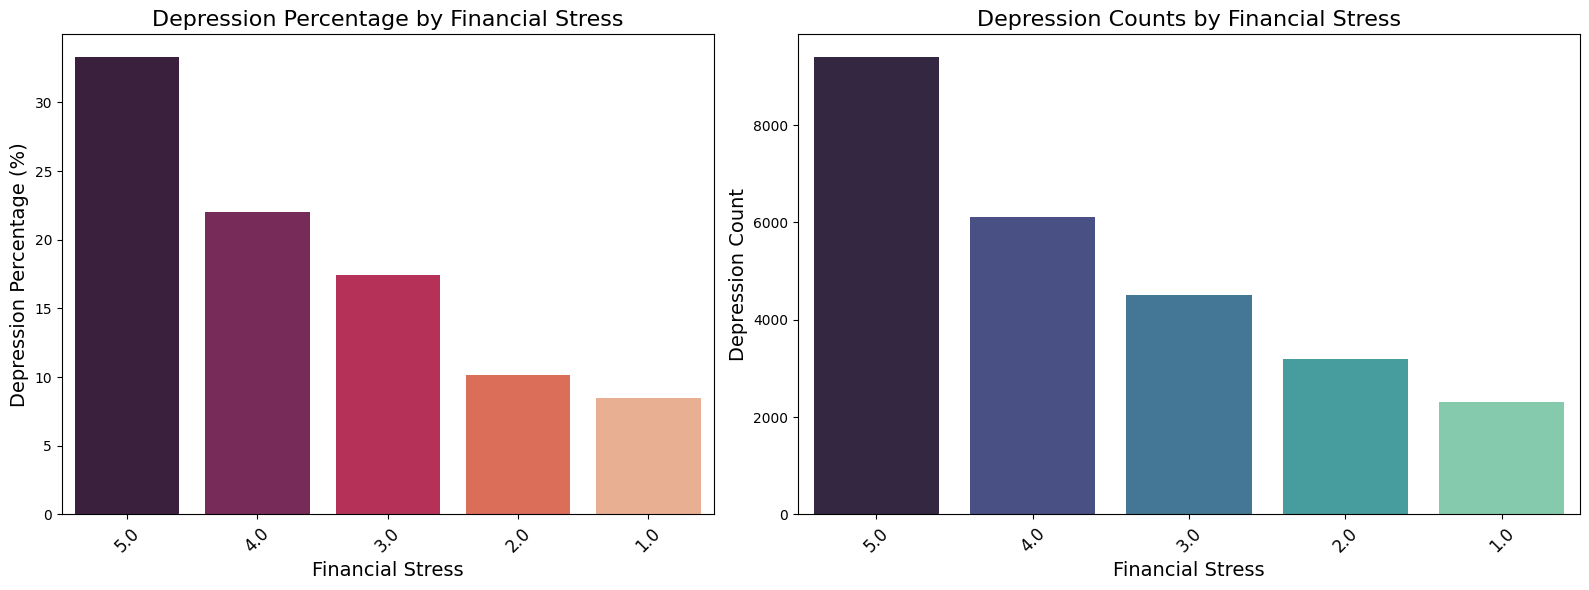

Family History of Mental Illness
No     70758
Yes    69942
Name: count, dtype: int64


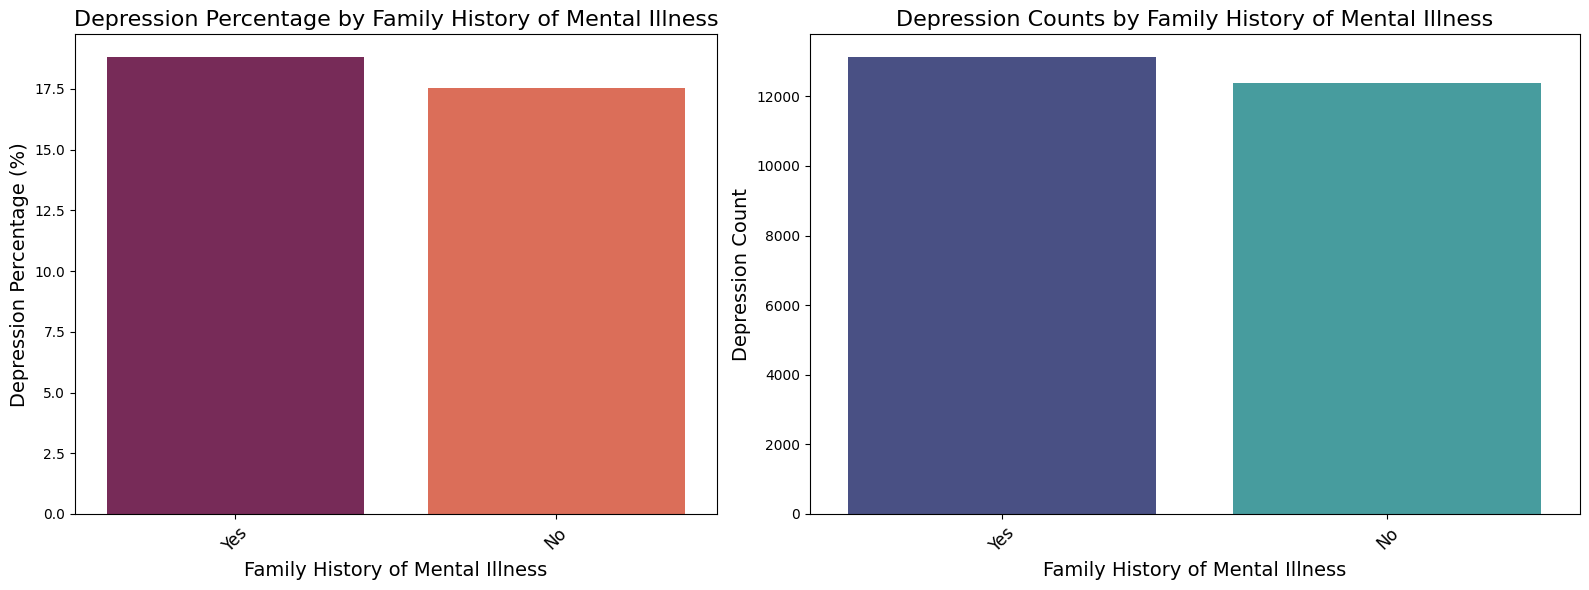

Depression
0    115133
1     25567
Name: count, dtype: int64


In [3]:
def plot_feature(feature):
    if feature == 'Profession':
        grouped = df_prof.groupby(feature)['Depression']
        percentages = (grouped.sum() / grouped.count() * 100).sort_values(ascending=False).head(10)
        
        groups = df_prof.groupby(col)['Depression'].sum().sort_values(ascending=False).head(10)
    else:
        grouped = df_ana.groupby(feature)['Depression']
        percentages = (grouped.sum() / grouped.count() * 100).sort_values(ascending=False).head(10)
        
        groups = df_ana.groupby(col)['Depression'].sum().sort_values(ascending=False).head(10)
    
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.2]})
    
    # Bar chart for percentages
    sns.barplot(
        x=percentages.index.astype(str),  # Convert to string to ensure proper ordering
        y=percentages.values,
        palette='rocket',
        ax=axes[0]
    )
    axes[0].set_title(f"Depression Percentage by {feature}", fontsize=16)
    axes[0].set_xlabel(feature, fontsize=14)
    axes[0].set_ylabel("Depression Percentage (%)", fontsize=14)
    axes[0].tick_params(axis='x', rotation=45, labelsize=12)

    # Bar chart for counts
    sns.barplot(
        x=groups.index.astype(str),  # Convert to string to ensure proper ordering
        y=groups.values,
        palette='mako',
        ax=axes[1]
    )
    axes[1].set_title(f"Depression Counts by {feature}", fontsize=16)
    axes[1].set_xlabel(feature, fontsize=14)
    axes[1].set_ylabel("Depression Count", fontsize=14)
    axes[1].tick_params(axis='x', rotation=45, labelsize=12)

    # Save plots
    # if feature == 'Have you ever had suicidal thoughts ?':
    #     plt.savefig("charts/Suicidal thoughts.png", bbox_inches='tight')
    # elif feature == 'Work/Study Hours':
    #     plt.savefig("charts/WorkStudyHours.png", bbox_inches='tight')
    # else:
    #     plt.savefig("charts/" + feature + ".png", bbox_inches='tight')

    # Adjust layout
    plt.tight_layout()
    plt.show()


for col in df_ana.columns:
    print(df[col].value_counts().head())
    if col not in ['Depression']:
        plot_feature(col)


#### Bayesian Optimization

In [4]:
# Prepare features for catboost
cat_feats = [0, 2, 3, 9, 10, 11, 12, 15] # Categorical features without id, name, city

cat_train = Pool(data=x_train, label=y_train, cat_features=cat_feats)
cat_test = Pool(data=x_test, label=y_test, cat_features=cat_feats)


# Objective function to maximize
def catboost_objective(learning_rate, depth, l2_leaf_reg, bagging_temperature):
    # Initialize the model with hyperparameters
    model = CatBoostClassifier(
        iterations=200,  # Fixed number of iterations
        learning_rate=learning_rate,
        depth=int(depth),  # Depth must be an integer
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        verbose=0  # Suppress output
    )
    
    # Train the model
    model.fit(cat_train)
    
    # Predict on test set
    cat_pred = model.predict(cat_test)
    
    # Evaluate using accuracy
    accuracy = accuracy_score(y_test, cat_pred).round(4)
    
    return accuracy


# Define the hyperparameter search space
param_bounds = {
    'learning_rate': (0.01, 0.3),  # Learning rate bounds
    'depth': (4, 10),  # Depth bounds (as float, convert to int in the function)
    'l2_leaf_reg': (1, 10),  # L2 regularization strength
    'bagging_temperature': (0, 1)  # Bagging temperature bounds
}


# Initialize the optimizer
optimizer = BayesianOptimization(
    f=catboost_objective,  # Objective function
    pbounds=param_bounds,  # Parameter bounds
    random_state=42,  # For reproducibility
    verbose=2  # Print progress
)

# Run the optimization
optimizer.maximize(
    init_points=5,  # Number of initial random points
    n_iter=25  # Number of optimization iterations
)


# Get the best parameters
best_params = optimizer.max['params']
best_params['depth'] = int(best_params['depth'])  # Convert depth to an integer
print("Best parameters:", best_params)


# Train the final model with the best parameters
final_model = CatBoostClassifier(
    iterations=200,
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    bagging_temperature=best_params['bagging_temperature'],
    verbose=0
)

final_model.fit(cat_train)

# Predict and evaluate
final_pred = final_model.predict(cat_test)
final_accuracy = accuracy_score(y_test, final_pred).round(4)
final_precision = precision_score(y_test, final_pred).round(4)
final_f1 = f1_score(y_test, final_pred).round(4)

print(f"Final Model\naccuracy: {final_accuracy}, precision: {final_precision}, f1: {final_f1}")

##### Results
# without preprocessing: 0.9403
# removing name and id: 0.9396
# adding munged dietary and sleep: 0.9410
# adding munged city: 0.9406 removed afterwards
# adding munged degree: 0.9418 removed afterwards
# dropped city to increase generalization: 0.9407
# removed diet munge: 0.9424                                final model
# removed diet sleep instead: 0.9410 removed afterwards
# dropped cgpa: 0.9424 removed afterwards
# munged profession: 0.9427 removed afterwards
# new munged degree: 0.9425

# final model: 0.9424
# final model without bayesian: 0.9415

# Best parameters: {'bagging_temperature': 0.15601864044243652, 'depth': 4, 'l2_leaf_reg': 1.5227525095137953, 'learning_rate': 0.2611910822747312}
# Final Model
# accuracy: 0.9424, precision: 0.8589, f1: 0.8393

|   iter    |  target   | baggin... |   depth   | l2_lea... | learni... |
-------------------------------------------------------------------------
| 1         | 0.9398    | 0.3745    | 9.704     | 7.588     | 0.1836    |
| 2         | 0.9424    | 0.156     | 4.936     | 1.523     | 0.2612    |
| 3         | 0.9396    | 0.6011    | 8.248     | 1.185     | 0.2913    |
| 4         | 0.9409    | 0.8324    | 5.274     | 2.636     | 0.06319   |
| 5         | 0.9408    | 0.3042    | 7.149     | 4.888     | 0.09446   |
| 6         | 0.9418    | 0.1161    | 4.276     | 1.367     | 0.2581    |
| 7         | 0.9411    | 0.6443    | 5.338     | 1.037     | 0.06776   |
| 8         | 0.9412    | 0.04323   | 4.709     | 2.187     | 0.1098    |
| 9         | 0.9412    | 0.2126    | 4.877     | 1.503     | 0.2399    |
| 10        | 0.9415    | 0.1249    | 4.977     | 1.424     | 0.2899    |
| 11        | 0.9397    | 0.9383    | 8.238     | 5.051     | 0.2996    |
| 12        | 0.9404    | 0.7752    | 

#### Stratified K-Fold

In [5]:
# StratifiedKfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
i=0
for train_index, test_index in skf.split(x, y):
    i+= 1
    print(f"fold {i}")
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_pool = Pool(data=x_train, label=y_train, cat_features=cat_feats)
    test_pool = Pool(data=x_test, label=y_test, cat_features=cat_feats)
    
    cat_model = CatBoostClassifier(
        iterations=200,
        learning_rate=best_params['learning_rate'],
        depth=best_params['depth'],
        l2_leaf_reg=best_params['l2_leaf_reg'],
        bagging_temperature=best_params['bagging_temperature'],
        verbose=0
    )

    cat_model.fit(train_pool)
    y_pred = cat_model.predict(test_pool)
    score = accuracy_score(y_test, y_pred)
    print(f"accuracy: {score:.4f}")
    scores.append(accuracy_score(y_test, y_pred))

mean_accuracy = np.mean(scores)
print(f"Mean Accuracy: {mean_accuracy:.4f}")

#### RECORDED RESULTS - Accuracy is the priority in the competition
# cat with all - accuracy: 0.9391, precision: 0.8449, f1: 0.8311
# + munged dietary habits + without degree - accuracy: 0.9392, precision: 0.8437, f1: 0.8318    best f1 score
# cat without city - accuracy: 0.9383, precision: 0.8428, f1: 0.8288    decrease                remove city to increase generalization
# + without degree - accuracy: 0.9386, precision: 0.8429, f1: 0.8299    increase
# + munged dietary habits - accuracy: 0.9393, precision: 0.8443, f1: 0.8317                     best accuracy

# new dietary munge accuracy: 0.9398, precision: 0.834, f1: 0.8345

# + new sleep munge accuracy: 0.9411, precision: 0.8492, f1: 0.8324

# no munge accuracy: 0.9393, precision: 0.8455, f1: 0.8314

# no nothing : 0.9400
# removed id and name: 0.9397
# munged diet and sleep: 0.9397
# munged city: 0.9397       removed
# munged degree: 0.9398     removed
# dropped city: 0.9394
# removed diet munge: 0.9395        final model
# removed sleep munge instead: 0.9395   removed
# munged profession: 0.9393 removed
# new munged degree: 0.9397 removed

# final model: 0.9395
# final model without bayesian: 0.9388

fold 1
accuracy: 0.9385
fold 2
accuracy: 0.9394
fold 3
accuracy: 0.9405
fold 4
accuracy: 0.9394
fold 5
accuracy: 0.9398
Mean Accuracy: 0.9395


#### Model Analysis

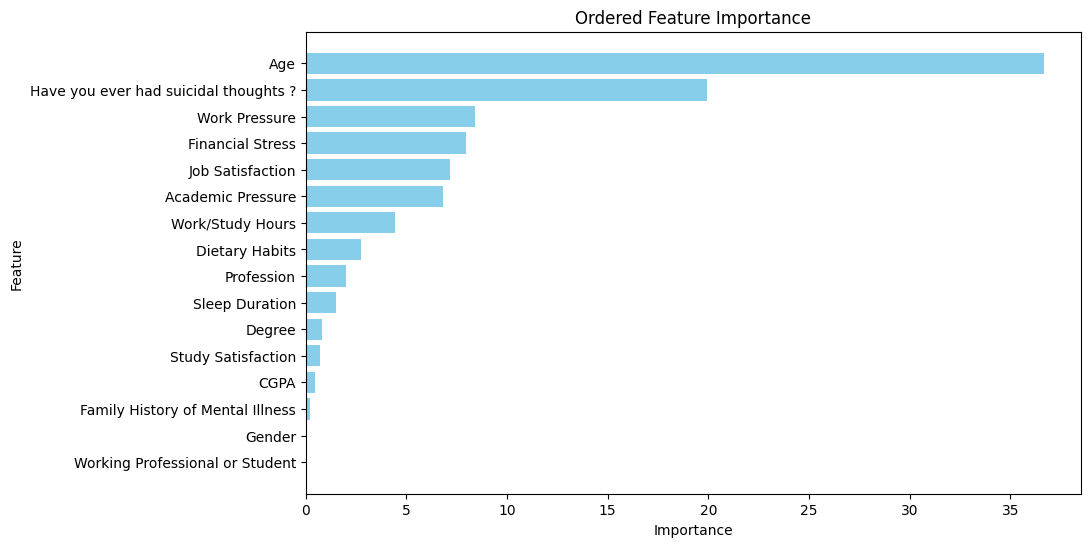

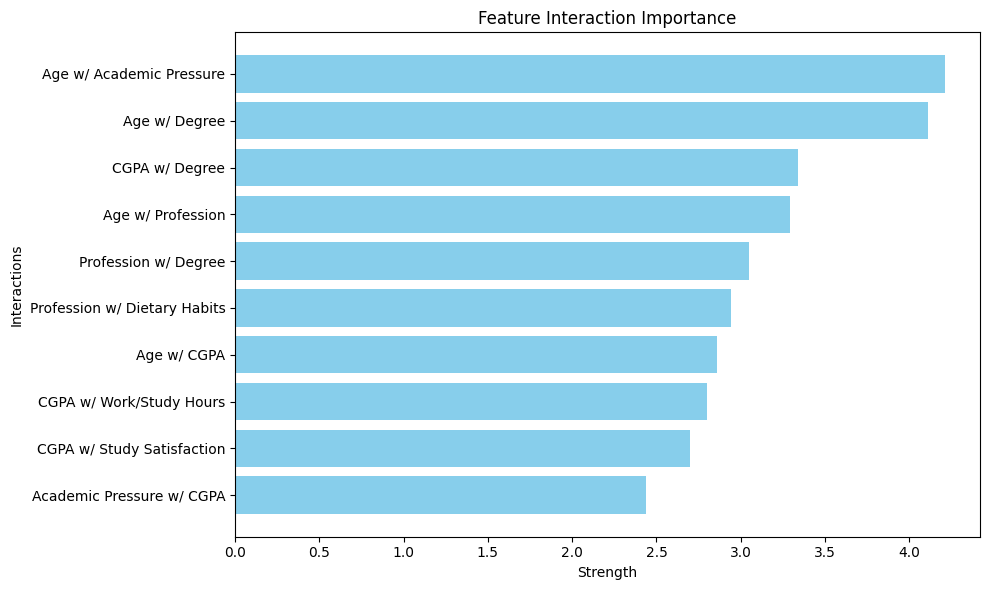

In [6]:
# Plot feature importance
importances = final_model.get_feature_importance()
feature_names = final_model.feature_names_

# Combine feature names and their importances, then sort by importance
features_and_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Unzip the sorted features and their importances
sorted_feature_names, sorted_importances = zip(*features_and_importances)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Ordered Feature Importance")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top

plt.savefig("charts/Feature Importance.png", bbox_inches='tight')

plt.show()


# Feature interaction importances to the model 
interaction_importances = final_model.get_feature_importance(type='Interaction')
interactions = []

for interaction in interaction_importances:
    inter = []
    for idx, value in enumerate(interaction):
        if idx < 2:
            # Extract feature name using the index
            feature_index = int(value)
            inter.append(x_train.columns[feature_index])
        elif idx == 2:
            # Append rounded importance value
            inter.append(round(value, 3))
            interactions.append(inter)
            break

# Extract interactions
relationships = [f"{item[0]} w/ {item[1]}" for item in interactions[:10]]
strengths = [item[2] for item in interactions[:10]]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(relationships, strengths, color='skyblue')

# Add labels and title
plt.xlabel('Strength')
plt.ylabel('Interactions')
plt.title('Feature Interaction Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top

# Display the chart
plt.tight_layout()

plt.savefig("charts/Feature Interactions.png", bbox_inches='tight')

plt.show()


#### Competition

In [7]:
# Prepare test dataset
df_test_munged = df_test.copy()

data = df_test_munged.drop(['id', 'Name', 'City'], axis=1)

data.fillna({'Profession': 'none', 'Dietary Habits': 'none', 'Degree' : 'none'}, inplace=True)

final_model.fit(cat_train)

# Predicting
sub_pred = final_model.predict(data)

submission = pd.read_csv("submission.csv")
submission['Depression'] = sub_pred

submission.to_csv('submission.csv', index=False)

display(sub_pred)

# We made a late submission so we weren't in the competition
# Scores and placements:
#### AFTER CHANGES
# no preprocessing: 0.94009
# sleep and dietary munge: 0.94048
# +- city munge: 0.94024
# +- degree munge: 0.94001
# remove city: 0.94027 ?
# without city + sleep munge: 0.94083 winner winner chicken dinner leaderboard place: 349/2687
# without city + diet munge: 0.94011
# without city + sleep munge + munged profession: 0.93550
# without city + sleep munge + new munged degree: 0.94048

# final model without bayesian: 0.93905

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [8]:
# Testing
print(x.dtypes)

# Predict if a single individual is at the risk of depression example:
final_model.predict(['Male', 27, 'Working Professional', 'Data Scientist', np.nan, 3, 7, np.nan, 4, '8 hours', 'Moderate', 'Master', 'Yes', 8, 2, 'No'])

Gender                                    object
Age                                      float64
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
dtype: object


1